<h3> Load libraries </h3>

In [1]:
import os
os.environ['user'] ='ansh.jain'
os.environ['password'] = '.Ld6FCV7WcsqrezGgntThGOE'

import prestodb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from dateutil import tz
from datetime import datetime
import scipy
import matplotlib.ticker as mtick
from sklearn.preprocessing import MultiLabelBinarizer

def convert(row):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz(row['timezone'])
    utc = datetime.strptime(row['created_hour_str'], '%Y-%m-%d %H:%M:%S.%f')
    utc = utc.replace(tzinfo=from_zone)
    target = utc.astimezone(to_zone)
    return target.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3]
  
def get_col(sr):
    name=sr.idxmin()
    value = sr[name]
    return pd.Series([value, name])
  
def get_col_max(sr):
    name=sr.idxmax()
    value = sr[name]
    return pd.Series([value, name])

def query(sql):
    user = 'ansh.jain'
    password = '.Ld6FCV7WcsqrezGgntThGOE'
    #if you stored them in environment then 
    #import os
    #user = os.environ["PRESTO_USER"]
    #password = os.environ["PRESTO_PASSWORD"]
    conn = prestodb.dbapi.connect(
        host = 'common.bolt.cp.ahana.cloud',
        port = 443,
        user = user,
        catalog = 'glue',
        http_scheme = 'https',
        auth = prestodb.auth.BasicAuthentication(user, password)
    )
    cur = conn.cursor()
    cur.execute(sql)
    queryFetch = cur.fetchall()
    conn.close()
    queryResults = pd.DataFrame.from_records(queryFetch, columns = [i[0] for i in cur.description])
    return(queryResults)

<h3> Build ETL </h3>

In [2]:
start_date = "'2023-01-25'"
start_time = "'2023-01-25 11:00:00'"
end_date = "'2023-02-25'"

In [3]:
#Bolt Market vs Food
market = """
select 
    provider_id 
from ng_delivery.delivery_provider_provider_trait
where trait_id = 145 and deleted = False
group by 1
"""
market = query(market)
market_provider = tuple(market['provider_id'].tolist())

In [4]:
#Pull in city/country data
country = """
SELECT
    id, name, country_code
FROM ng_public.admin_system_city
"""
country = query(country)

In [5]:
#Load data
data = f"""
WITH all_cart_views as
(
SELECT
    replace(distinct_id, 'delivery-') user_id
    , cart_id
    , providerid
    , orderprice
    , date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s') eventtime
    , smallorderfee
    , case when providerid in {market_provider} then 'market' else 'food' end providercategory
    , deliveryfee
    , cityid
    , totalproductquantity
FROM mixpanel_food.cart_viewed
WHERE
    date(concat(partition_0, '-', partition_1, '-', partition_2)) >= date({start_date}) - interval '1' day and cast(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s') as timestamp) >= cast({start_time} as timestamp)
    and date(concat(partition_0, '-', partition_1, '-', partition_2)) <= date({end_date})
), first_cart_view AS
(
SELECT
    cart_id
    , min(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s')) first_eventtime --get the first vart view for each cart
FROM mixpanel_food.cart_viewed
WHERE
    date(concat(partition_0, '-', partition_1, '-', partition_2)) >= date({start_date}) - interval '1' day and cast(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s') as timestamp) >= cast({start_time} as timestamp) 
    and date(concat(partition_0, '-', partition_1, '-', partition_2)) <= date({end_date})
GROUP BY 1
), cart_view_final AS --this is the key cart view table, with the details of the cart as they were on the first cart view
(
SELECT
    a.user_id
    , a.cart_id
    , a.providerid
    , a.orderprice
    , a.eventtime
    , a.smallorderfee
    , a.providercategory
    , a.deliveryfee
    , a.cityid
    , a.totalproductquantity
FROM all_cart_views a INNER JOIN first_cart_view f
    ON a.cart_id = f.cart_id and a.eventtime = f.first_eventtime
GROUP BY 1,2,3,4,5,6,7,8,9,10
), products_recommended AS
(
SELECT
    cart_id
    , date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s') eventtime
    , number_of_products
    , product_id_list
FROM mixpanel_food.products_recommended
WHERE
    date(concat(partition_0, '-', partition_1, '-', partition_2)) >= date({start_date}) - interval '1' day and cast(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s') as timestamp) >= cast({start_time} as timestamp)
    and date(concat(partition_0, '-', partition_1, '-', partition_2)) <= date({end_date})
), first_products_recommended AS --first time the product recommended item was triggered
(
SELECT
    cart_id
    , min(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s')) first_eventtime
FROM mixpanel_food.products_recommended
WHERE
    date(concat(partition_0, '-', partition_1, '-', partition_2)) >= date({start_date}) - interval '1' day and cast(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s') as timestamp) >= cast({start_time} as timestamp)
    and date(concat(partition_0, '-', partition_1, '-', partition_2)) <= date({end_date})
GROUP BY 1
), products_recommended_final AS --final product recommended table with details as on the first product recommended event
(
SELECT
    p.*
FROM products_recommended p INNER JOIN first_products_recommended fp 
    ON p.cart_id = fp.cart_id and p.eventtime = fp.first_eventtime
GROUP BY 1,2,3,4
), product_added AS --product added through recommendations
(
SELECT
    cart_id
    , min(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s')) first_product_add
    , max(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s')) last_product_add
    , count(*) number_products_added
    , avg(price) avg_price
    , min(position) first_position
    , max(position) last_position
FROM mixpanel_food.product_added
WHERE
    date(concat(partition_0, '-', partition_1, '-', partition_2)) >= date({start_date}) - interval '1' day and cast(date_format(from_unixtime(time), '%Y-%m-%d %H:%i:%s') as timestamp) >= cast({start_time} as timestamp)
    and date(concat(partition_0, '-', partition_1, '-', partition_2)) <= date({end_date})
    and source = 'recommendation'
GROUP BY 1
), orders AS --bring in order details from order_order for each cart
(
SELECT
    master_basket_id
    , cast(created as timestamp) order_time
    , provider_price
    , small_order_fee
FROM ng_delivery.delivery_order_order
WHERE
    date(created_date) >= date({start_date}) and cast(created as timestamp) >= cast({start_time} as timestamp)   
    and date(created_date) <= date({end_date}) + interval '1' day
)
SELECT
    c.user_id
    , c.cart_id
    , c.providerid
    , c.orderprice/rate initial_cart_orderprice_eur
    , c.eventtime initial_cart_view_time
    , c.smallorderfee/rate initial_cart_smallorderfee_eur
    , c.providercategory
    , c.deliveryfee/rate initial_cart_deliveryfee_eur
    , c.cityid
    , c.totalproductquantity initial_cart_product_quantity
    , r.eventtime product_recommended_time
    , r.number_of_products products_recommended
    , r.product_id_list recommended_product_list
    , pa.first_product_add first_recommended_product_added
    , pa.last_product_add last_recommended_product_added
    , pa.number_products_added number_recommended_products_added
    , pa.avg_price/rate avg_price_recommended_products_added
    , pa.first_position first_position_recommended_products_added
    , pa.last_position last_position_recommended_products_added
    , o.order_time
    , o.provider_price/rate order_provider_price
    , o.small_order_fee/rate order_smallorderfee
FROM cart_view_final c
LEFT JOIN products_recommended_final r
    ON c.cart_id = r.cart_id
LEFT JOIN product_added pa
    ON c.cart_id = pa.cart_id
LEFT JOIN orders o
    ON c.cart_id = o.master_basket_id
LEFT JOIN (
SELECT
    city.id, co.currency, rate.rate, rate.valid_on
FROM ng_public.admin_system_city city INNER JOIN ng_public.admin_system_country co --bring everything in EUR
    ON city.country_code = co.code inner join ng_public.vw_currency_exchange_rates rate 
    ON co.currency = rate.currency
where
    date(valid_on) >= date({start_date})
) cu
    ON c.cityid = cu.id and date(cast(c.eventtime as timestamp)) = date(cast(cu.valid_on as timestamp))
"""

data = query(data)

#Merge with country
data = pd.merge(data, country, how='left', left_on='cityid',right_on='id')

In [8]:
#Additional Provider data
provider = f"""
WITH provider_segment as
    (
    SELECT 
        pt.provider_id 
        , array_join(array_agg(t.id), ',') trait_id
    FROM ng_delivery.delivery_provider_provider_trait pt INNER JOIN ng_delivery.delivery_provider_trait t
        ON pt.trait_id = t.id
        AND t.id in (58,59,60,61)
        AND pt.deleted = False
    GROUP BY 1
    ), provider_cuisine as
    (
    SELECT
        pt.provider_id 
        , array_join(array_agg(translation_key), ',') tags
    FROM ng_delivery.delivery_provider_provider_tag pt LEFT JOIN 
    (
    SELECT 
        t.translation_key 
        , t.id
    FROM ng_delivery.delivery_provider_tag t
    GROUP BY 1,2
    ) tags
        ON pt.tag_id = tags.id
    GROUP BY 1
    )
SELECT
    provider_segment.provider_id
    , trait_id
    , tags
FROM provider_segment left join provider_cuisine
    ON provider_segment.provider_id = provider_cuisine.provider_id
"""
provider = query(provider)

#Merge with main data
data = pd.merge(data, provider, how='left', left_on=['providerid'], right_on=['provider_id']).drop('provider_id', axis=1)

<h3> Data Transformations & Filtering </h3>

In [15]:
#Modify data types
data['order_smallorderfee'] = data['order_smallorderfee'].astype(float)
data['order_provider_price'] = data['order_provider_price'].astype(float)
data['order_time'] = pd.to_datetime(data['order_time'])
data['initial_cart_view_time'] = pd.to_datetime(data['initial_cart_view_time'])

#Feature engineering
data['date'] = pd.to_datetime(data['initial_cart_view_time'], format="%Y-%m-%d").dt.strftime("%Y-%m-%d")
data['recommended_product_added'] = (data['number_recommended_products_added'].notnull()).astype(int)
data['order_placed'] = (data['order_time'].notnull()).astype(int)
data['has_recommendations'] = (data['products_recommended'] > 0).astype(int)
data['had_initial_small_order_fee'] = (data['initial_cart_smallorderfee_eur'] > 0).astype(int)
data['had_order_smallorderfee'] = (data['order_smallorderfee'] > 0).astype(int)
data['inital_cart_free_delivery'] = (data['initial_cart_deliveryfee_eur'] == 0).astype(int)
data['time_first_cart_view_to_order'] = (data['order_time'] - data['initial_cart_view_time'])/pd.Timedelta(minutes = 1)

#Remove today's date from dataset
data = data[data['date'] != data['date'].max()]

In [16]:
#Make the tags a list
data['tags_list'] = data['tags'].fillna('None')
data['tags_list'] = data['tags_list'].str.split(',')

#Create dummies for key tags
tag_groups = [['italian', 'pizza', 'pasta'], ['coffee', 'breakfast', 'dessert', 'pastry', 'croissants', 'brunch', 'pancakes', 'juice', 'smoothie', 'sandwich', 'cake', 'ice_cream'], ['mexican', 'taco'], ['asian', 'japanese', 'sushi', 'noodles', 'thai', 'chinese', 'vietnamese', 'indian', 'curry', 'poke', 'wok'],
             ['kebab', 'turkish', 'doner', 'shawarma'], ['healthy', 'vegan', 'vegetarian', 'salad'], ['american', 'burgers'], ['casual', 'daily-menu', 'lunch'],
             ['traditional'], ['meat', 'chicken', 'wings', 'grill'], ['fast_food', 'street_food'], ['european'], ['grocery', 'stores'], ['african', 'nigerian'], ['czech'], ['portuguese']]

for group in tag_groups:
    data[f'type_{group[0]}'] = np.where(data['tags_list'].apply(lambda x: any([k in x for k in group])) == 1, 1,0)

In [18]:
#Make the tags a list
data['tags_list'] = data['tags'].fillna('None')
data['tags_list'] = data['tags_list'].str.split(',')

#Create sparse matrix of all tags
s = data['tags_list']
mlb = MultiLabelBinarizer()
all_tags = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=data.index)

#Join back with main data frame
data = pd.concat([data, all_tags], axis=1)

#Drop tag list columns
data.drop(['tags', 'tags_list'], axis=1, inplace=True)

In [19]:
#Convert traits into binary variables
data['trait_id'] = data['trait_id'].fillna('None')
data[['trait1', 'trait2']] = data['trait_id'].str.split(',', expand = True)

#Get the segment
data['IC'] = ((data['trait1'] == '58') | (data['trait2']=='58')).astype(int)
data['KeyAccount'] = ((data['trait1'] == '59') | (data['trait2']=='59')).astype(int)
data['LocalHero'] = ((data['trait1'] == '60') | (data['trait2']=='60')).astype(int)
data['SMB'] = ((data['trait1'] == '61') | (data['trait2']=='61')).astype(int)
data['NotMatched'] = ((data['trait1'] == '62') | (data['trait2']=='62')).astype(int)

#Drop unneccesary fields
data.drop(['trait_id', 'trait1', 'trait2'], axis=1, inplace=True)

In [20]:
#Carts for which recommendation was eligible
rec = data[data['products_recommended'].notnull()]
non_rec = data[~data['products_recommended'].notnull()]

#Carts which had at least one recommendation
had_rec = rec[rec['products_recommended']>=1]
added = had_rec[had_rec['recommended_product_added'] == 1]
added_ordered = added[added['order_placed']==1]

<h3> Basic Analysis </h3>

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='products_recommended'>

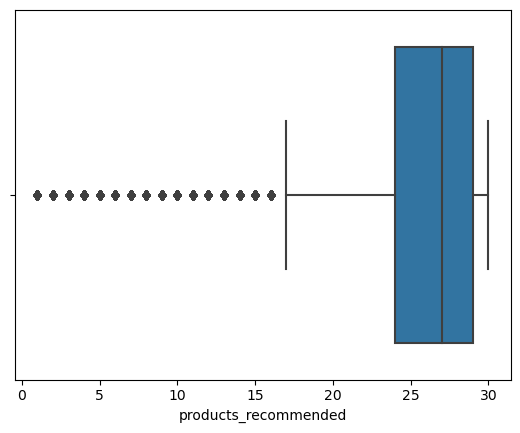

In [20]:
sns.boxplot(had_rec[had_rec['providercategory']=='food']['products_recommended'])

In [21]:
had_rec.groupby(['order_placed']).agg(
avg_products_recommended = ('products_recommended', 'mean')
, avg_rec_products_added = ('number_recommended_products_added', 'mean')
, prop_recommended_product_added = ('recommended_product_added', 'mean')
).reset_index()

,order_placed,avg_products_recommended,avg_rec_products_added,prop_recommended_product_added
0,0,25.063401,1.268030,0.039781
1,1,25.374459,1.232319,0.049206


In [22]:
had_rec.groupby(['order_placed','providercategory']).agg(
avg_products_recommended = ('products_recommended', 'mean')
, avg_rec_products_added = ('number_recommended_products_added', 'mean')
, prop_recommended_product_added = ('recommended_product_added', 'mean')
).reset_index()

,order_placed,providercategory,avg_products_recommended,avg_rec_products_added,prop_recommended_product_added
0,0,food,25.066970,1.255221,0.039342
1,0,market,24.974676,1.515179,0.050695
2,1,food,25.372927,1.218627,0.047432
3,1,market,25.416126,1.413604,0.097448


/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

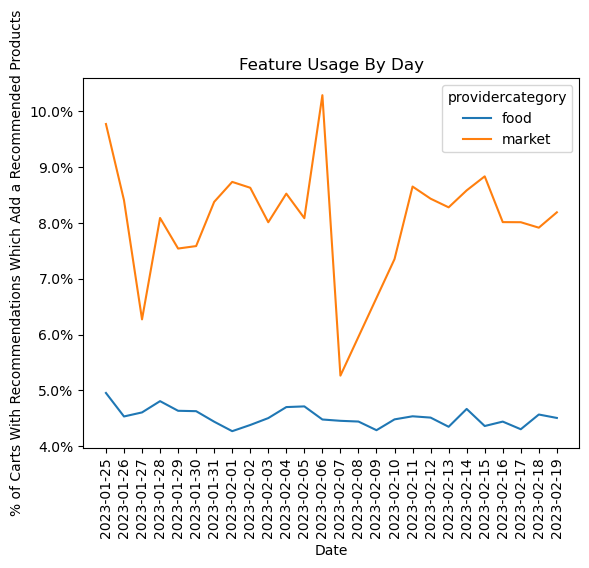

In [25]:
by_day = had_rec.groupby(['date', 'providercategory']).agg(prop_carts_added_recommended_product = ('recommended_product_added', 'mean'))\
.reset_index()

ax = sns.lineplot(by_day['date'], by_day['prop_carts_added_recommended_product']
                 , hue = by_day['providercategory'])
ax.set_title("Feature Usage By Day")
ax.set_xlabel("Date")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel("% of Carts With Recommendations Which Add a Recommended Products")
plt.xticks(rotation = 90)

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


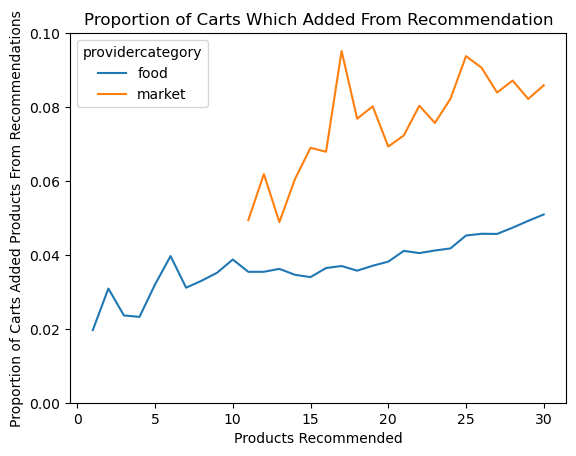

In [34]:
rec_add_by_count = had_rec.groupby(['products_recommended', 'providercategory']).agg(
count_carts = ('cart_id', 'count')
, avg_recommended_product_added = ('recommended_product_added', 'mean')
, avg_order_placed = ('order_placed', 'mean')
, prop_IC = ('IC', 'mean')
, prop_LocalHero = ('LocalHero', 'mean')
, prop_SMB = ('SMB','mean')
, prop_KeyAccount = ('KeyAccount','mean')
).reset_index()

#Restrict to at least 100 carts
rec_add_by_count = rec_add_by_count[rec_add_by_count['count_carts'] >= 100]

ax = sns.lineplot(rec_add_by_count['products_recommended'], rec_add_by_count['avg_recommended_product_added']
                 , hue=rec_add_by_count['providercategory'])
ax.set_title("Proportion of Carts Which Added From Recommendation")
ax.set_ylabel("Proportion of Carts Added Products From Recommendations")
ax.set_xlabel("Products Recommended")
plt.ylim(0,0.1)

#Break up by food/market
rec_add_by_count_food = rec_add_by_count[rec_add_by_count['providercategory']=='food']
rec_add_by_count_market = rec_add_by_count[rec_add_by_count['providercategory']=='market']

In [38]:
had_rec[had_rec['LocalHero']==1].groupby(['products_recommended', 'providercategory']).agg(
count_carts = ('cart_id', 'count')
, avg_recommended_product_added = ('recommended_product_added', 'mean')
, avg_order_placed = ('order_placed', 'mean')
, prop_IC = ('IC', 'mean')
, prop_LocalHero = ('LocalHero', 'mean')
, prop_SMB = ('SMB','mean')
, prop_KeyAccount = ('KeyAccount','mean')
).reset_index()

,products_recommended,providercategory,count_carts,avg_recommended_product_added,avg_order_placed,prop_IC,prop_LocalHero,prop_SMB,prop_KeyAccount
0,1.0,food,2444,0.012275,0.754501,0.0,1.0,0.000000,0.000000
1,2.0,food,1986,0.023162,0.721551,0.0,1.0,0.000000,0.000000
2,3.0,food,3307,0.019958,0.746296,0.0,1.0,0.000000,0.000000
3,4.0,food,1781,0.024705,0.685570,0.0,1.0,0.000000,0.000000
4,5.0,food,1976,0.038462,0.688765,0.0,1.0,0.000000,0.000000
5,6.0,food,1772,0.032731,0.658014,0.0,1.0,0.000000,0.000000
6,7.0,food,2340,0.025641,0.654274,0.0,1.0,0.000000,0.000000
7,8.0,food,2443,0.028244,0.676627,0.0,1.0,0.000000,0.000000
8,9.0,food,2734,0.031090,0.664960,0.0,1.0,0.000000,0.000000
9,10.0,food,2786,0.031228,0.679828,0.0,1.0,0.000000,0.000000


In [35]:
rec_add_by_count_food

,products_recommended,providercategory,count_carts,avg_recommended_product_added,avg_order_placed,prop_IC,prop_LocalHero,prop_SMB,prop_KeyAccount
0,1.0,food,5136,0.019665,0.702882,0.074961,0.475857,0.222547,0.224688
1,2.0,food,5893,0.030884,0.662142,0.078568,0.337010,0.327338,0.254200
3,3.0,food,7791,0.023617,0.675395,0.085868,0.424464,0.237582,0.245411
5,4.0,food,5941,0.023228,0.645346,0.037872,0.299781,0.251978,0.392527
7,5.0,food,6817,0.031979,0.631363,0.054129,0.289864,0.354848,0.292357
9,6.0,food,6528,0.039675,0.640472,0.070006,0.271446,0.416973,0.231924
11,7.0,food,7166,0.031119,0.632850,0.076333,0.326542,0.357801,0.228161
13,8.0,food,7421,0.033014,0.663927,0.061717,0.329201,0.310336,0.284598
15,9.0,food,10174,0.035188,0.683704,0.051111,0.268724,0.352172,0.308925
17,10.0,food,12593,0.038752,0.689510,0.065989,0.221234,0.307075,0.386405


In [ ]:
data

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Products Recommended')

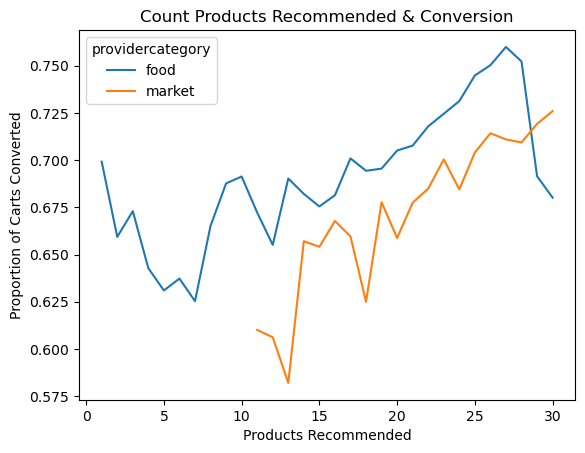

In [153]:
ax = sns.lineplot(rec_add_by_count['products_recommended'], rec_add_by_count['avg_order_placed']
                 , hue = rec_add_by_count['providercategory'])
ax.set_title("Count Products Recommended & Conversion")
ax.set_ylabel("Proportion of Carts Converted")
ax.set_xlabel("Products Recommended")

<h3> Position of Recommended Item </h3>

In [154]:
added_position = added[added['first_position_recommended_products_added'].notnull()]
added_position['first_position_recommended_products_added'] = added_position['first_position_recommended_products_added'] + 1

/var/folders/1b/n1w1nv4114b3skc46ywqb4kc0000gp/T/ipykernel_1701/3571414133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  added_position['first_position_recommended_products_added'] = added_position['first_position_recommended_products_added'] + 1


Text(0, 0.5, 'Proportion of Products Added from Recommendations')

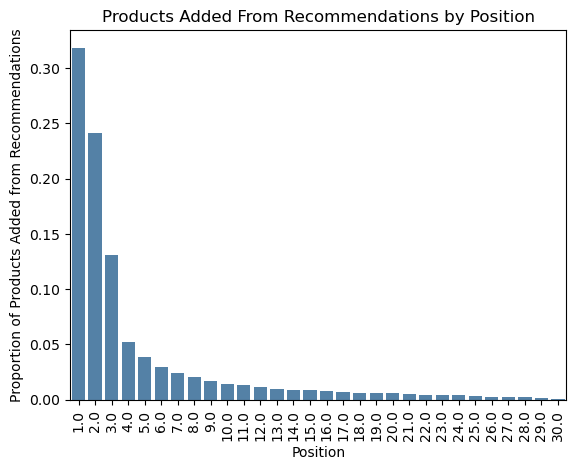

In [155]:
added_position_prop = pd.DataFrame(added_position['first_position_recommended_products_added'].value_counts(normalize = True)).reset_index()
added_position_prop.columns = ['position', 'prop_of_carts']
ax = sns.barplot(x = added_position_prop['position'], y = added_position_prop['prop_of_carts'], color='steelblue')
plt.xticks(rotation=90)
ax.set_title("Products Added From Recommendations by Position")
ax.set_xlabel("Position")
ax.set_ylabel("Proportion of Products Added from Recommendations")


-1.0     0.880105
 1.0     0.024725
 2.0     0.015825
 3.0     0.010121
 4.0     0.007235
 5.0     0.006570
 6.0     0.006148
 7.0     0.004927
 8.0     0.004750
 9.0     0.003995
 10.0    0.003795
 14.0    0.003152
 13.0    0.003041
 11.0    0.002974
 12.0    0.002952
 16.0    0.002708
 17.0    0.002264
 19.0    0.002242
 15.0    0.002219
 18.0    0.001975
 20.0    0.001931
 21.0    0.001620
 22.0    0.001110
 24.0    0.001021
 23.0    0.000999
 25.0    0.000932
 26.0    0.000466
 27.0    0.000200
Name: diff, dtype: float64

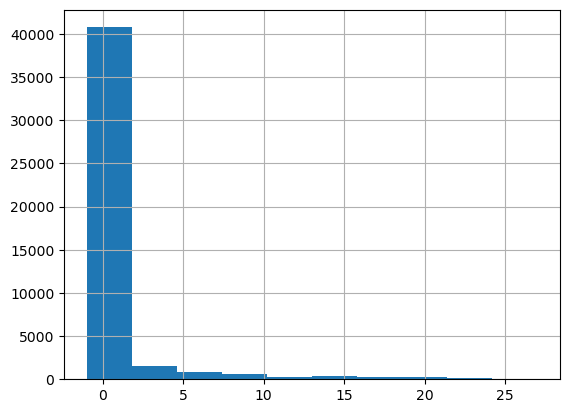

In [132]:
#For carts with more than one recommended product added
multiple_recs_added = added_position[added_position['first_position_recommended_products_added'] != added_position['last_position_recommended_products_added']][['first_position_recommended_products_added', 'last_position_recommended_products_added']]
multiple_recs_added['diff'] = multiple_recs_added['last_position_recommended_products_added'] - multiple_recs_added['first_position_recommended_products_added']
ax = multiple_recs_added['diff'].hist()
multiple_recs_added['diff'].value_counts(normalize=True)

<h3> Who adds it, who doesn't </h3>

In [156]:
had_rec.groupby(['recommended_product_added', 'providercategory']).agg(
count_carts = ('cart_id', 'count')
, avg_initial_cart_orderprice_eur = ('initial_cart_orderprice_eur', 'mean')
, avg_initial_cart_product_quantity = ('initial_cart_product_quantity', 'mean')
, avg_initial_cart_smallorderfee_eur = ('initial_cart_smallorderfee_eur', 'mean')
, prop_had_initial_small_order_fee = ('had_initial_small_order_fee', 'mean')
, prop_order_placed = ('order_placed', 'mean')
, avg_order_smallorderfee = ('order_smallorderfee', 'mean')
, prop_had_order_smallorderfee = ('had_order_smallorderfee', 'mean')
).reset_index()

,recommended_product_added,providercategory,count_carts,avg_initial_cart_orderprice_eur,avg_initial_cart_product_quantity,avg_initial_cart_smallorderfee_eur,prop_had_initial_small_order_fee,prop_order_placed,avg_order_smallorderfee,prop_had_order_smallorderfee
0,0,food,1600213,16.082221,2.222835,0.266134,0.183976,0.717297,0.069330,0.061963
1,0,market,53368,19.492749,7.497770,1.337223,0.471556,0.689627,0.268996,0.098805
2,1,food,75856,15.822349,2.252057,0.423372,0.261812,0.753994,0.060285,0.058057
3,1,market,4913,20.355135,8.280684,1.325002,0.456951,0.817220,0.187669,0.087726


In [33]:
had_rec[had_rec['had_initial_small_order_fee']==1].groupby(['recommended_product_added', 'providercategory']).agg(
count_carts = ('cart_id', 'count')
, avg_initial_cart_orderprice_eur = ('initial_cart_orderprice_eur', 'mean')
, avg_initial_cart_product_quantity = ('initial_cart_product_quantity', 'mean')
, avg_initial_cart_smallorderfee_eur = ('initial_cart_smallorderfee_eur', 'mean')
, avg_order_provider_price = ('order_provider_price', 'mean')
, prop_order_placed = ('order_placed', 'mean')
, avg_order_smallorderfee = ('order_smallorderfee', 'mean')
, prop_had_order_smallorderfee = ('had_order_smallorderfee', 'mean')
).reset_index()

,recommended_product_added,providercategory,count_carts,avg_initial_cart_orderprice_eur,avg_initial_cart_product_quantity,avg_initial_cart_smallorderfee_eur,avg_order_provider_price,prop_order_placed,avg_order_smallorderfee,prop_had_order_smallorderfee
0,0,food,332613,9.572536,1.369312,1.444703,10.306531,0.532123,0.487318,0.320177
1,0,market,31081,10.392034,3.364467,2.855471,16.161912,0.523728,0.730046,0.195714
2,1,food,22363,9.523184,1.410813,1.605679,11.529980,0.668739,0.240048,0.200197
3,1,market,2794,10.806412,3.841804,2.893153,19.534652,0.740515,0.437712,0.182534


In [32]:
had_rec[had_rec['had_initial_small_order_fee']==1].groupby(['recommended_product_added']).agg(
count_carts = ('cart_id', 'count')
, avg_initial_cart_orderprice_eur = ('initial_cart_orderprice_eur', 'mean')
, avg_initial_cart_product_quantity = ('initial_cart_product_quantity', 'mean')
, avg_initial_cart_smallorderfee_eur = ('initial_cart_smallorderfee_eur', 'mean')
, avg_order_provider_price = ('order_provider_price', 'mean')
, prop_order_placed = ('order_placed', 'mean')
, avg_order_smallorderfee = ('order_smallorderfee', 'mean')
, prop_had_order_smallorderfee = ('had_order_smallorderfee', 'mean')
).reset_index()

,recommended_product_added,count_carts,avg_initial_cart_orderprice_eur,avg_initial_cart_product_quantity,avg_initial_cart_smallorderfee_eur,avg_order_provider_price,prop_order_placed,avg_order_smallorderfee,prop_had_order_smallorderfee
0,0,363694,9.642569,1.539816,1.565266,10.799698,0.531406,0.507761,0.309540
1,1,25157,9.665703,1.680805,1.748669,12.502822,0.676710,0.264071,0.198235


In [159]:
#Now by city
small_order_fee_city = had_rec.groupby(['cityid','recommended_product_added']).agg(
count_carts = ('cart_id', 'count')
, avg_initial_cart_orderprice_eur = ('initial_cart_orderprice_eur', 'mean')
, avg_initial_cart_product_quantity = ('initial_cart_product_quantity', 'mean')
, avg_initial_cart_smallorderfee_eur = ('initial_cart_smallorderfee_eur', 'mean')
, prop_had_initial_small_order_fee = ('had_initial_small_order_fee', 'mean')
, prop_order_placed = ('order_placed', 'mean')
, avg_order_smallorderfee = ('order_smallorderfee', 'mean')
, prop_had_order_smallorderfee = ('had_order_smallorderfee', 'mean')
).reset_index()[['cityid', 'recommended_product_added', 'count_carts', 'prop_had_initial_small_order_fee', 'prop_had_order_smallorderfee']]

In [160]:
small_order_fee_city_piv = small_order_fee_city.pivot(columns = ['recommended_product_added'], index=['cityid'], values=['count_carts', 'prop_had_initial_small_order_fee', 'prop_had_order_smallorderfee'])

small_order_fee_city_piv.columns = small_order_fee_city_piv.columns.droplevel()
small_order_fee_city_piv.reset_index(inplace=True)
small_order_fee_city_piv.columns = ['cityid'
                                    , 'count_carts_rec_product_not_added'
                                    , 'count_carts_rec_product_added'
                                    , 'prop_had_initial_small_order_fee_rec_product_not_added'
                                    , 'prop_had_initial_small_order_fee_rec_product_added'
                                    , 'prop_had_order_smallorderfee_rec_product_not_added'
                                    , 'prop_had_order_smallorderfee_rec_product_added']


In [161]:
small_order_fee_city_piv['diff_prop_had_initial_small_order_fee'] = small_order_fee_city_piv['prop_had_initial_small_order_fee_rec_product_added'] - small_order_fee_city_piv['prop_had_initial_small_order_fee_rec_product_not_added']

small_order_fee_city_piv['diff_prop_had_initial_small_order_fee'].median()

0.08972599862789296

In [163]:
had_rec.groupby(['had_initial_small_order_fee','providercategory']).agg(
prop_recommended_product_added = ('recommended_product_added','mean')
)

prop_recommended_product_added
had_initial_small_order_fee providercategory                                
0                           food                                    0.041119
                            market                                  0.086427
1                           food                                    0.063196
                            market                                  0.081901

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


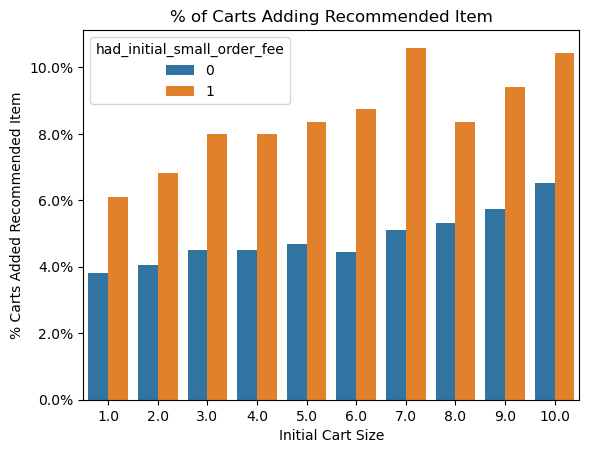

In [82]:
product_added_init = had_rec.groupby(['initial_cart_product_quantity','had_initial_small_order_fee']).agg(
count_carts = ('cart_id', 'count')
, prop_recommended_product_added = ('recommended_product_added','mean')
).head(21).reset_index()

product_added_init = product_added_init[product_added_init['initial_cart_product_quantity']>0]
ax = sns.barplot(product_added_init['initial_cart_product_quantity']
                 , product_added_init['prop_recommended_product_added']
                 , hue = product_added_init['had_initial_small_order_fee'])
ax.set_title("% of Carts Adding Recommended Item")
ax.set_ylabel("% Carts Added Recommended Item")
ax.set_xlabel("Initial Cart Size")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


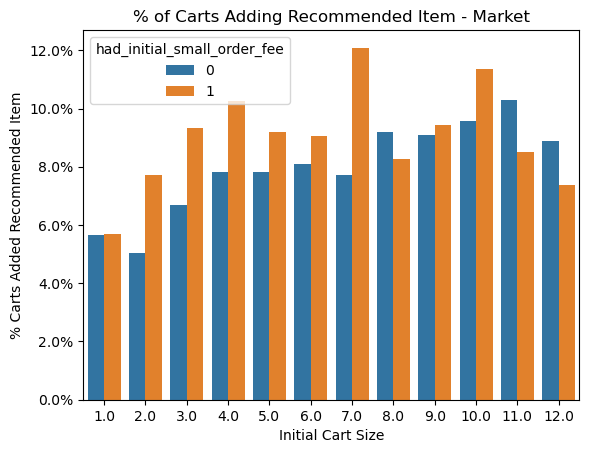

In [181]:
product_added_init_market = had_rec[had_rec['providercategory']=='market'].groupby(['initial_cart_product_quantity','had_initial_small_order_fee']).agg(
count_carts = ('cart_id', 'count')
, prop_recommended_product_added = ('recommended_product_added','mean')
).head(24).reset_index()

product_added_init_market = product_added_init_market[product_added_init_market['initial_cart_product_quantity']>0]
ax = sns.barplot(product_added_init_market['initial_cart_product_quantity']
                 , product_added_init_market['prop_recommended_product_added']
                 , hue = product_added_init_market['had_initial_small_order_fee'])
ax.set_title("% of Carts Adding Recommended Item - Market")
ax.set_ylabel("% Carts Added Recommended Item")
ax.set_xlabel("Initial Cart Size")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [27]:
products_added_value = had_rec[had_rec['recommended_product_added']==1][['initial_cart_orderprice_eur',
                                                  'cityid', 'providercategory',
                                                                         'avg_price_recommended_products_added',
                                                  'number_recommended_products_added']]

products_added_value['total_price_recommended_products_added'] = products_added_value['avg_price_recommended_products_added']\
* products_added_value['number_recommended_products_added']

print((products_added_value['total_price_recommended_products_added']/products_added_value['initial_cart_orderprice_eur']).mean())
print(products_added_value['avg_price_recommended_products_added'].mean())


0.3332482052655216
3.4672175144026975


In [29]:
for cat in ['food', 'market']:
    products_added_value_cat = products_added_value[products_added_value['providercategory']==cat]
    print(cat)
    print((products_added_value_cat['avg_price_recommended_products_added']/products_added_value_cat['initial_cart_orderprice_eur']).mean())




food
0.2862253695631988
market
0.1253135648922677


In [116]:
products_added_value.groupby('cityid').agg({
    'avg_price_recommended_products_added':'mean'
}).reset_index().sort_values('avg_price_recommended_products_added')

,cityid,avg_price_recommended_products_added
39,424.0,1.658678
63,498.0,1.787979
33,335.0,1.919016
61,491.0,1.939706
64,499.0,2.159564
...,...,...
47,437.0,4.695856
48,442.0,4.805863
55,457.0,4.828050
58,473.0,5.204348


In [210]:
had_rec[had_rec['order_placed']==1][['providercategory','recommended_product_added','had_initial_small_order_fee', 'initial_cart_orderprice_eur', 'order_provider_price'
                                     ]].groupby(['providercategory','had_initial_small_order_fee', 'recommended_product_added']).agg(
    avg_initial_cart_orderprice_eur = ('initial_cart_orderprice_eur','mean')
, avg_order_provider_price = ('order_provider_price', 'mean'))

avg_initial_cart_orderprice_eur  \
providercategory had_initial_small_order_fee recommended_product_added                                    
food             0                           0                                                17.956498   
                                             1                                                18.335370   
                 1                           0                                                 9.924902   
                                             1                                                 9.758932   
market           0                           0                                                27.728762   
                                             1                                                28.207313   
                 1                           0                                                11.199662   
                                             1                                                11.028054   

                                                                        avg_order_provider_price  
providercategory had_initial_small_order_fee recommended_product_added                            
food             0                           0                                         17.395709  
                                             1                                         19.592819  
                 1                           0                                         10.283795  
                                             1                                         11.533364  
market           0                           0                                         29.356329  
                                             1                                         32.704692  
                 1                           0                                         16.045497  
                                             1                                         19.598876

In [209]:
had_rec.columns

Index(['user_id', 'cart_id', 'providerid', 'initial_cart_orderprice_eur',
       'initial_cart_view_time', 'initial_cart_smallorderfee_eur',
       'providercategory', 'initial_cart_deliveryfee_eur', 'cityid',
       'initial_cart_product_quantity', 'product_recommended_time',
       'products_recommended', 'recommended_product_list',
       'first_recommended_product_added', 'last_recommended_product_added',
       'number_recommended_products_added',
       'avg_price_recommended_products_added',
       'first_position_recommended_products_added',
       'last_position_recommended_products_added', 'order_time',
       'order_provider_price', 'order_smallorderfee',
       'recommended_product_added', 'order_placed', 'has_recommendations',
       'had_initial_small_order_fee', 'had_order_smallorderfee',
       'inital_cart_free_delivery', 'id', 'name', 'country_code'],
      dtype='object')

In [215]:
had_rec.groupby(['country_code','providercategory']).agg(
count_carts = ('cart_id', 'count')
, avg_initial_cart_product_quantity = ('initial_cart_product_quantity','mean')
, avg_products_recommended = ('products_recommended','mean')
).reset_index()

,country_code,providercategory,count_carts,avg_initial_cart_product_quantity,avg_products_recommended
0,az,food,108326,2.559339,25.486162
1,cy,food,64203,2.676729,27.061492
2,cz,food,126503,1.926120,25.385224
3,ee,food,119844,2.312239,26.292756
4,ee,market,15481,7.721142,26.366837
5,ge,food,34477,2.479769,23.809148
6,gh,food,86888,1.448359,20.724001
7,hr,food,32926,1.671445,23.522171
8,ke,food,30544,2.059193,24.981699
9,lt,food,172973,2.274748,25.547623


In [217]:
rec.groupby(['country_code','providercategory']).agg(
count_carts = ('cart_id', 'count')
, avg_initial_cart_product_quantity = ('initial_cart_product_quantity','mean')
, prop_has_recommendations = ('has_recommendations','mean')
).reset_index()

,country_code,providercategory,count_carts,avg_initial_cart_product_quantity,prop_has_recommendations
0,az,food,119015,2.567601,0.910188
1,cy,food,68414,2.664893,0.938448
2,cz,food,151373,1.920488,0.835704
3,ee,food,134038,2.319611,0.894105
4,ee,market,25697,7.824182,0.602444
5,ge,food,37540,2.468700,0.918407
6,gh,food,110987,1.437556,0.782866
7,hr,food,37060,1.672126,0.888451
8,hu,food,2,3.500000,0.000000
9,ke,food,44636,2.021126,0.684291


In [218]:
rec.groupby(['has_recommendations']).agg(
prop_order_placed = ('order_placed','mean')
)

,prop_order_placed
has_recommendations,
0,0.673381
1,0.718334


In [219]:
non_rec['order_placed'].mean()

0.7047688113388808

<h3> City-level Analysis </h3>

In [63]:
#Small order fees by city
small_order_fee_by_city = had_rec.groupby('cityid').agg(
count_carts = ('cart_id', 'count')
, count_carts_had_initial_small_order_fee = ('had_initial_small_order_fee', 'sum')
).reset_index()

#Merge with country
small_order_fee_by_city = pd.merge(small_order_fee_by_city, country, how='left', left_on=['cityid'],right_on='id').drop('id', axis=1)

#Remove cities with fewer than < 1000 carts
# small_order_fee_by_city = small_order_fee_by_city[small_order_fee_by_city['count_carts'] >= 2000]
# small_order_fee_by_city.sort_values('prop_carts_had_initial_small_order_fee', ascending=False)

In [65]:
small_order_fee_by_city.groupby('country_code').agg({
    'count_carts':'sum'
    , 'count_carts_had_initial_small_order_fee':'sum'
}).reset_index()

,count_carts,count_carts_had_initial_small_order_fee
country_code,,
az,107915,20408
cy,63987,9838
cz,126449,15132
ee,135180,27287
ge,34389,2884
gh,86877,5574
hr,32923,10533
ke,30486,2533
lt,180659,72980


Text(0.5, 0, 'City')

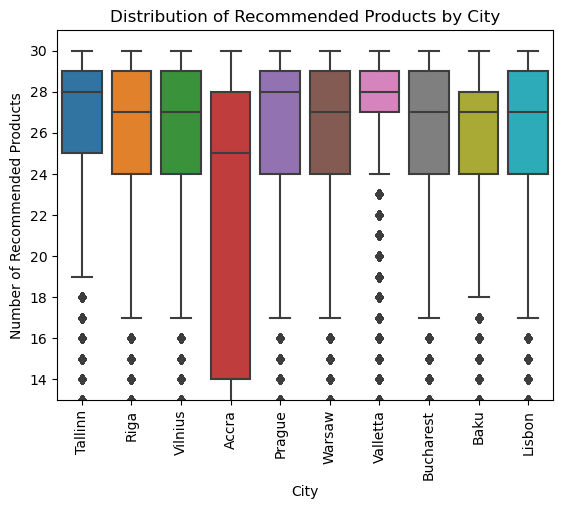

In [120]:
#Get data for recommendations in top six cities
top_ten_cities = had_rec[had_rec['cityid'].isin(had_rec['cityid'].value_counts().head(10).keys().tolist())]

ax = sns.boxplot(data = top_ten_cities, y = 'products_recommended', x=top_ten_cities['cityid'].astype(object))
ax.set_xticklabels(['Tallinn','Riga','Vilnius','Accra','Prague','Warsaw','Valletta','Bucharest','Baku','Lisbon'])
plt.ylim(13,31)
plt.xticks(rotation=90)
ax.set_title("Distribution of Recommended Products by City")
ax.set_ylabel("Number of Recommended Products")
ax.set_xlabel("City")

In [139]:
had_rec['more_than_28_recs'] = (had_rec['products_recommended'] > 28).astype(int)

by_city = rec.groupby('cityid').agg(
count_carts = ('cart_id', 'count')
, prop_carts_with_recs = ('has_recommendations', 'mean')
, prop_carts_more_than_28_recs = ('more_than_28_recs', 'mean')
).reset_index().sort_values('count_carts', ascending = False)

by_city_had_rec = had_rec.groupby('cityid').agg(
count_carts = ('cart_id', 'count')
, prop_carts_more_than_28_recs = ('more_than_28_recs', 'mean')
).reset_index().sort_values('count_carts', ascending = False)

/var/folders/1b/n1w1nv4114b3skc46ywqb4kc0000gp/T/ipykernel_2524/3965699377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  had_rec['more_than_28_recs'] = (had_rec['products_recommended'] > 28).astype(int)


/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(15.0, 31.0)

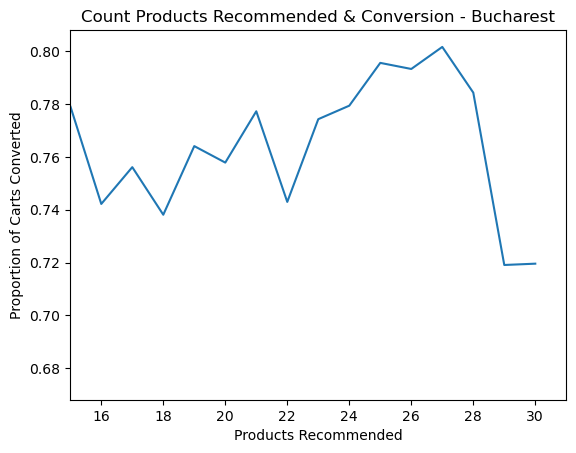

In [141]:
#Specific cities
bucharest = had_rec[had_rec['cityid']==325]
bucharest_rec_add_by_count = bucharest.groupby(['products_recommended']).agg(
count_carts = ('cart_id', 'count')
, avg_recommended_product_added = ('recommended_product_added', 'mean')
, avg_order_placed = ('order_placed', 'mean')
).reset_index()

ax = sns.lineplot(bucharest_rec_add_by_count['products_recommended'], bucharest_rec_add_by_count['avg_order_placed'])
ax.set_title("Count Products Recommended & Conversion - Bucharest")
ax.set_ylabel("Proportion of Carts Converted")
ax.set_xlabel("Products Recommended")
plt.xlim(15,31)

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(15.0, 31.0)

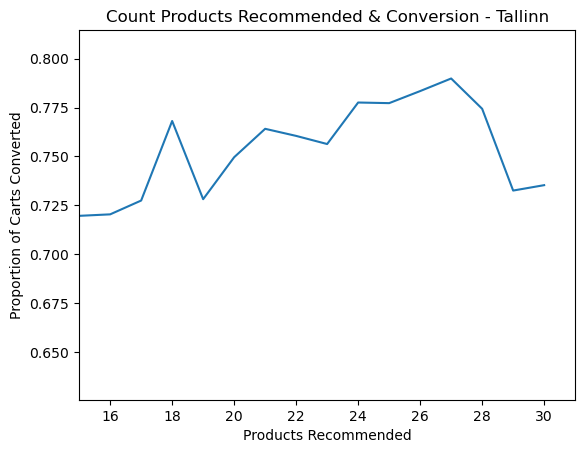

In [142]:
#Specific cities
tallinn = had_rec[had_rec['cityid']==1]
tallinn_rec_add_by_count = tallinn.groupby(['products_recommended']).agg(
count_carts = ('cart_id', 'count')
, avg_recommended_product_added = ('recommended_product_added', 'mean')
, avg_order_placed = ('order_placed', 'mean')
).reset_index()

ax = sns.lineplot(tallinn_rec_add_by_count['products_recommended'], tallinn_rec_add_by_count['avg_order_placed'])
ax.set_title("Count Products Recommended & Conversion - Tallinn")
ax.set_ylabel("Proportion of Carts Converted")
ax.set_xlabel("Products Recommended")
plt.xlim(15,31)

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(15.0, 31.0)

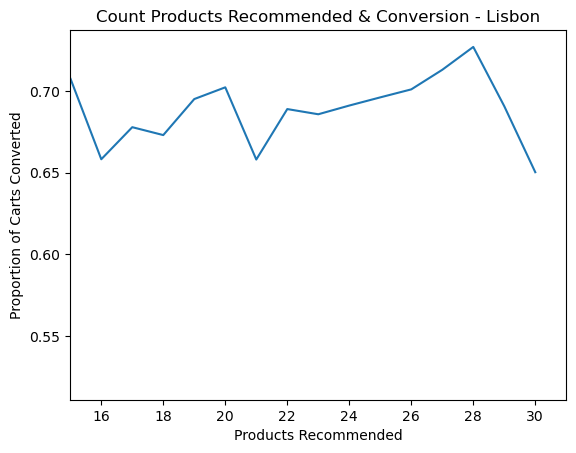

In [144]:
#Specific cities
lisbon = had_rec[had_rec['cityid']==386]
lisbon_rec_add_by_count = lisbon.groupby(['products_recommended']).agg(
count_carts = ('cart_id', 'count')
, avg_recommended_product_added = ('recommended_product_added', 'mean')
, avg_order_placed = ('order_placed', 'mean')
).reset_index()

ax = sns.lineplot(lisbon_rec_add_by_count['products_recommended'], lisbon_rec_add_by_count['avg_order_placed'])
ax.set_title("Count Products Recommended & Conversion - Lisbon")
ax.set_ylabel("Proportion of Carts Converted")
ax.set_xlabel("Products Recommended")
plt.xlim(15,31)

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(1.0, 1.3)

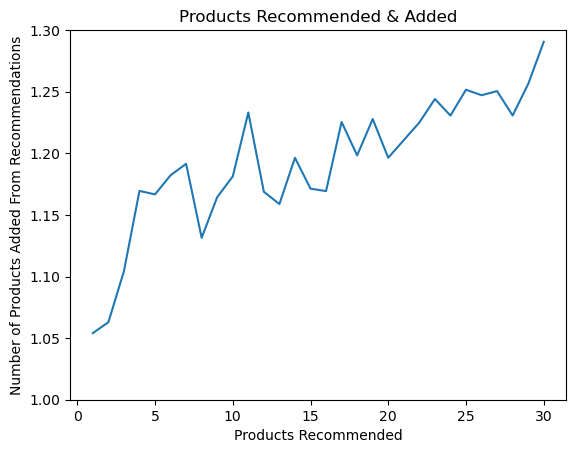

In [81]:
count_rec_added = added.groupby(['products_recommended']).agg(
count_carts = ('cart_id', 'count')
, avg_recommended_product_added = ('number_recommended_products_added', 'mean')
).reset_index()

ax = sns.lineplot(count_rec_added['products_recommended'], count_rec_added['avg_recommended_product_added'])
ax.set_title("Products Recommended & Added")
ax.set_ylabel("Number of Products Added From Recommendations")
ax.set_xlabel("Products Recommended")
plt.ylim(1,1.3)

In [6]:
from statsmodels.stats.power import tt_ind_solve_power

tt_ind_solve_power(effect_size = 0.02,
                                 nobs1=None,
                                 alpha=0.05, 
                                 power=0.8, 
                                 ratio=1, 
                                 alternative='two-sided')

39245.263510769844

/Users/anshjain/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

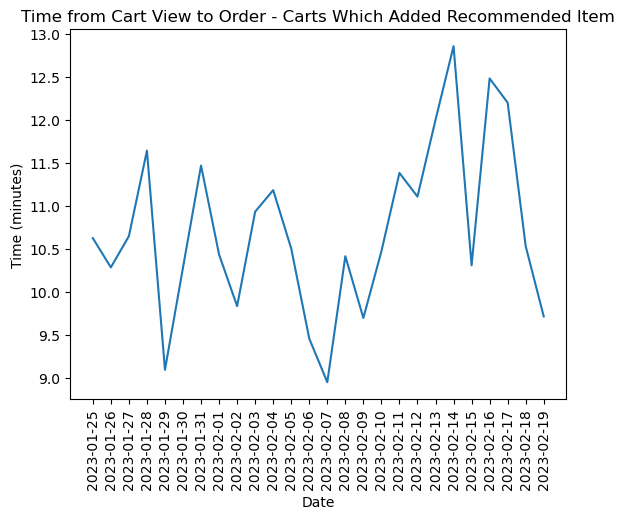

In [56]:
by_date = added_ordered.groupby('date').agg(avg_time_first_cart_view_to_order = ('time_first_cart_view_to_order','mean')).reset_index()
by_date = by_date[by_date['date'] < '2023-02-20']
ax = sns.lineplot(by_date['date'], by_date['avg_time_first_cart_view_to_order'])
ax.set_title("Time from Cart View to Order - Carts Which Added Recommended Item")
ax.set_xlabel("Date")
ax.set_ylabel("Time (minutes)")
plt.xticks(rotation=90)